# Task 1

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

## Import raw data and merge the data

In [2]:
Nextbike_bochum_raw = pd.read_csv("./dataset/bochum.csv")
Nextbike_leipzig_raw = pd.read_csv("./dataset/leipzig.csv")
Nextbike_raw = Nextbike_bochum_raw.append(Nextbike_leipzig_raw)

Nextbike_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202697 entries, 0 to 185326
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   day            202697 non-null  object 
 1   time           202697 non-null  object 
 2   b_number       202697 non-null  int64  
 3   city           202697 non-null  object 
 4   trip_duration  202697 non-null  object 
 5   orig_lat       202697 non-null  float64
 6   orig_lng       202697 non-null  float64
 7   dest_lat       202697 non-null  float64
 8   dest_lng       202697 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 15.5+ MB


## Look for null values

In [3]:
Nextbike_raw.isnull().sum().sort_values(ascending=False)

dest_lng         0
dest_lat         0
orig_lng         0
orig_lat         0
trip_duration    0
city             0
b_number         0
time             0
day              0
dtype: int64

In [4]:
#Copy dataset for cleaning
Nextbike_clean = Nextbike_raw

## Correct Data Types

In [5]:
#Converting Trip Length to timedelta
Nextbike_clean['trip_duration'] = pd.to_timedelta(Nextbike_clean['trip_duration'])

#Converting start-time to datetime
Nextbike_clean['timestamp'] = pd.to_datetime(Nextbike_clean['day'] + ' ' +  Nextbike_clean['time'])
Nextbike_clean.drop(columns=['day','time'], inplace = True)

## Add columns for analysis

In [190]:
#Round datetime and extract possible categorisation attributes
Nextbike_clean['timestamp_rounded'] = Nextbike_clean['timestamp'].dt.floor('H')

Nextbike_clean['Weekday'] = Nextbike_clean['timestamp_rounded'].dt.weekday

Nextbike_clean['Time'] = Nextbike_clean['timestamp_rounded'].dt.time
Nextbike_clean["Time"] = Nextbike_clean["Time"].astype(str).str[:2].astype(int)

Nextbike_clean["date"] = Nextbike_clean.timestamp.dt.date.astype(str)

#take trip duration in minutes, calculate 1€ per 30 minutes of usage
Nextbike_clean["revenue"] = np.ceil((Nextbike_clean.trip_duration.dt.total_seconds()/60) /30)


#output
Nextbike_clean

,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,timestamp,timestamp_rounded,Weekday,Time,date,revenue
0,683,bochum,0 days 00:10:00,51.489814,7.232856,51.479592,7.222239,2019-02-08 12:06:00,2019-02-08 12:00:00,4,12,2019-02-08,1.0
1,683,bochum,0 days 00:14:00,51.479592,7.222239,51.472366,7.250500,2019-02-10 01:58:00,2019-02-10 01:00:00,6,1,2019-02-10,1.0
2,683,bochum,0 days 00:28:00,51.472366,7.250500,51.479592,7.222239,2019-02-11 06:33:00,2019-02-11 06:00:00,0,6,2019-02-11,1.0
3,683,bochum,0 days 00:58:00,51.479592,7.222239,51.483023,7.215314,2019-02-11 13:31:00,2019-02-11 13:00:00,0,13,2019-02-11,2.0
4,683,bochum,0 days 00:22:00,51.483023,7.215314,51.479592,7.222239,2019-02-11 14:32:00,2019-02-11 14:00:00,0,14,2019-02-11,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
185322,99979,leipzig,0 days 00:07:00,51.468822,11.290048,51.468547,11.289899,2019-05-25 10:58:00,2019-05-25 10:00:00,5,10,2019-05-25,1.0
185323,99979,leipzig,0 days 01:16:00,51.468756,11.289723,51.469324,11.289366,2019-05-27 09:32:00,2019-05-27 09:00:00,0,9,2019-05-27,3.0
185324,99979,leipzig,0 days 00:03:00,51.469044,11.289348,51.469093,11.289432,2019-05-27 11:02:00,2019-05-27 11:00:00,0,11,2019-05-27,1.0
185325,99982,leipzig,0 days 01:44:00,51.341165,12.365045,51.341065,12.365005,2019-02-11 11:47:00,2019-02-11 11:00:00,0,11,2019-02-11,4.0




# Task 2

## Import Visualisation Libaries

In [129]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Split data for analysis

In [193]:
Nextbike_clean_l = Nextbike_clean[Nextbike_clean.city == "leipzig"]
Nextbike_clean_b = Nextbike_clean[Nextbike_clean.city == "bochum"]

df = Nextbike_clean_l[:]

## Find out size of the fleet
The idea is that a bike is recognized as part of the fleet if it has been rented in the last 7 days. So the size of the fleet is the amount of unique Bike IDs that have records for the last 7 days. We calculate this on a daily level to be precise yet not too intense to compute.

In [174]:
start_date = df.date.min()
end_date = df.date.max()
delta = pd.to_timedelta("1d")

dates = []
while start_date <= end_date:
    dates.append(start_date.strftime("%Y-%m-%d"))
    start_date += delta


fleet_size = pd.DataFrame([], index = dates, columns = ["search_array","fleet_size"]) 

search_array = []
for index, row in fleet_size.iterrows():
    search_array.append(index)
    if len(search_array) > 7:
        search_array.pop(0)
    #row["date_str"] = index
    row['search_array'] = search_array[:]
    row['fleet_size'] = df[df.date.astype(str).isin(search_array[:])].b_number.nunique()
    
fleet_size

,search_array,fleet_size
2019-02-01,[2019-02-01],256
2019-02-02,"[2019-02-01, 2019-02-02]",329
2019-02-03,"[2019-02-01, 2019-02-02, 2019-02-03]",350
2019-02-04,"[2019-02-01, 2019-02-02, 2019-02-03, 2019-02-04]",390
2019-02-05,"[2019-02-01, 2019-02-02, 2019-02-03, 2019-02-0...",421
...,...,...
2019-06-26,"[2019-06-20, 2019-06-21, 2019-06-22, 2019-06-2...",785
2019-06-27,"[2019-06-21, 2019-06-22, 2019-06-23, 2019-06-2...",787
2019-06-28,"[2019-06-22, 2019-06-23, 2019-06-24, 2019-06-2...",789
2019-06-29,"[2019-06-23, 2019-06-24, 2019-06-25, 2019-06-2...",795


### Test for this

In [169]:
searches = ["2019-06-24", "2019-06-25", "2019-06-26", "2019-06-27", "2019-06-28", "2019-06-29", "2019-06-30"]
Nextbike_clean_l = Nextbike_clean[Nextbike_clean.city == "leipzig"]
Nextbike_clean_l[Nextbike_clean_l.date.astype(str).isin(searches)].b_number.nunique()

790

## Analysis for revenue and fleet size

In [209]:
df_by_date = df.groupby("date").agg(
    revenue=('revenue', "sum"),
    trips=("b_number","count"),
    used_bikes=('b_number', pd.Series.nunique))

df_by_date.index.astype(str, copy = False)
fleet_size.index.astype(str, copy= False)

df_by_date_merged = fleet_size.join(df_by_date)
df_by_date_merged["usage"] = df_by_date_merged["used_bikes"] / df_by_date_merged["fleet_size"]

df_by_date_merged

,search_array,fleet_size,revenue,trips,used_bikes,usage
2019-02-01,[2019-02-01],256,785.0,659.0,256.0,1
2019-02-02,"[2019-02-01, 2019-02-02]",329,664.0,526.0,241.0,0.732523
2019-02-03,"[2019-02-01, 2019-02-02, 2019-02-03]",350,352.0,285.0,162.0,0.462857
2019-02-04,"[2019-02-01, 2019-02-02, 2019-02-03, 2019-02-04]",390,623.0,499.0,237.0,0.607692
2019-02-05,"[2019-02-01, 2019-02-02, 2019-02-03, 2019-02-0...",421,654.0,573.0,251.0,0.5962
...,...,...,...,...,...,...
2019-06-26,"[2019-06-20, 2019-06-21, 2019-06-22, 2019-06-2...",785,3039.0,2552.0,585.0,0.745223
2019-06-27,"[2019-06-21, 2019-06-22, 2019-06-23, 2019-06-2...",787,2993.0,2555.0,600.0,0.762389
2019-06-28,"[2019-06-22, 2019-06-23, 2019-06-24, 2019-06-2...",789,3417.0,2857.0,627.0,0.794677
2019-06-29,"[2019-06-23, 2019-06-24, 2019-06-25, 2019-06-2...",795,3737.0,2780.0,625.0,0.786164


## Visualisation

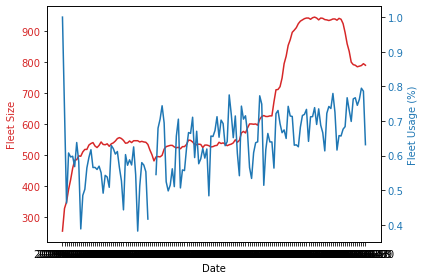

In [218]:
dates = df_by_date_merged.index
fleetsize = df_by_date_merged["fleet_size"]
usage = df_by_date_merged["usage"]


Fig_1, ax_1 = plt.subplots()


color = 'tab:red'
ax_1.set_xlabel('Date')
ax_1.set_ylabel('Fleet Size', color=color)
ax_1.plot(dates, fleetsize, color=color)
ax_1.tick_params(axis='y', labelcolor=color)

ax_2 = ax_1.twinx()  # instantiate a second axes that shares the same x-axis


color = 'tab:blue'

ax_2.set_ylabel("Fleet Usage (%)", color=color)
ax_2.plot(dates, usage, color=color)
ax_2.tick_params(axis='y', labelcolor=color)

Fig_1.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

## Group by rounded start time

In [123]:
df_by_time = df.groupby("Time").agg(
    mean_length=('trip_duration', lambda x: np.mean(x)),
    trip_count=('b_number', 'count'))

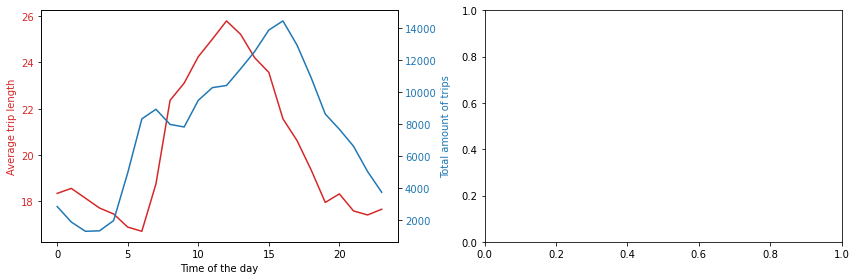

In [88]:
fig, (ax1, ax1_b) = plt.subplots(nrows = 1, ncols = 2, figsize= (12,4))

x = df_by_time.index
seconds = df_by_time["mean_length"].dt.total_seconds()/60
amount = df_by_time["trip_count"]

color = 'tab:red'
ax1.set_xlabel('Time of the day')
ax1.set_ylabel('Average trip length', color=color)
ax1.plot(x, seconds, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Total amount of trips', color=color)  # we already handled the x-label with ax1
ax2.plot(x, amount, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,timestamp,timestamp_rounded,Weekday,Time,date
2306,20199,leipzig,0 days 00:09:00,51.331342,12.358439,51.324615,12.336922,2019-02-01 10:06:00,2019-02-01 10:00:00,4,10,2019-02-01
2995,20205,leipzig,0 days 00:04:00,51.345991,12.399617,51.345084,12.406133,2019-02-01 17:24:00,2019-02-01 17:00:00,4,17,2019-02-01
2996,20205,leipzig,0 days 00:04:00,51.345084,12.406133,51.345538,12.414902,2019-02-01 17:48:00,2019-02-01 17:00:00,4,17,2019-02-01
2997,20205,leipzig,0 days 00:19:00,51.344861,12.414481,51.326982,12.374618,2019-02-02 14:29:00,2019-02-02 14:00:00,5,14,2019-02-02
2998,20205,leipzig,0 days 00:12:00,51.326796,12.374574,51.344213,12.390458,2019-02-02 19:19:00,2019-02-02 19:00:00,5,19,2019-02-02
...,...,...,...,...,...,...,...,...,...,...,...,...
170764,39062,leipzig,0 days 00:06:00,51.332416,12.395124,51.326524,12.388068,2019-02-01 18:59:00,2019-02-01 18:00:00,4,18,2019-02-01
170765,39062,leipzig,0 days 00:12:00,51.326166,12.387858,51.339462,12.379896,2019-02-02 15:25:00,2019-02-02 15:00:00,5,15,2019-02-02
170766,39062,leipzig,0 days 00:13:00,51.339378,12.379863,51.331267,12.404177,2019-02-02 18:20:00,2019-02-02 18:00:00,5,18,2019-02-02
171107,39063,leipzig,0 days 00:05:00,51.305261,12.381538,51.301198,12.384442,2019-02-02 00:07:00,2019-02-02 00:00:00,5,0,2019-02-02


In [1]:
import geopandas as gpd
geopandas.datasets.available

ModuleNotFoundError: No module named 'geopandas'